# Plots
<hr style="clear:both">

This notebook presents and displays our plot illustrating out story.


**Project Mentor:** [Shuo Wen](http://personnes.epfl.ch/shuo.wen) ([Email](shuo.wen@epfl.ch)),
**Authors:** Mahmoud Dokmak, Matthieu Borello, Léo Brunneau, Loïc Domingos, Bastien Armstrong

<hr style="clear:both">

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import scipy.stats as stats
from dash.dependencies import Input, Output
import dash
from dash import dcc, html
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact
from src.utils.results_utils import *

In [2]:
movies = pd.read_pickle('./data/Success_Metric.pkl')
movies.head()

,freebase_movie_id,imdb_id,item_id,movie_name,combined_release_date,movie_countries_final,movie_genres_final,Box_Office,inflation_adjusted_box_office_revenue,sa_score,rating,popularity,success_score,success_metric_scaled
30973,/m/083skw,031381,NaN,Gone with the Wind,1939-12-15,United States of America,"Film adaptation, Costume drama, Roadshow theat...",0.143767,0.996126,0.634957,0.785789,1.0,22.231248,5.000000
9888,/m/0k4d7,029583,NaN,Snow White and the Seven Dwarfs,1937-12-21,United States of America,"Romance Film, Musical, Fantasy, Family Film, A...",0.149518,1.000000,0.634957,0.696421,1.0,21.994133,4.944084
1036,/m/04j1zjw,034492,NaN,Bambi,1942-08-14,United States of America,"Adventure, Children's/Family, Animation, Comin...",0.096125,0.567962,0.634957,0.684211,1.0,18.501200,4.120385
66323,/m/0dtfn,076759,NaN,Star Wars Episode IV: A New Hope,1977-05-25,United States of America,"Science Fiction, Adventure, Fantasy, Coming of...",0.278692,0.442916,0.634957,0.810947,1.0,17.881039,3.974139
18216,/m/0dr_4,120338,1721.0,Titanic,1997-11-18,United States of America,"Tragedy, Costume drama, Historical fiction, Ac...",0.785462,0.471324,0.592075,0.714080,1.0,17.689057,3.928867


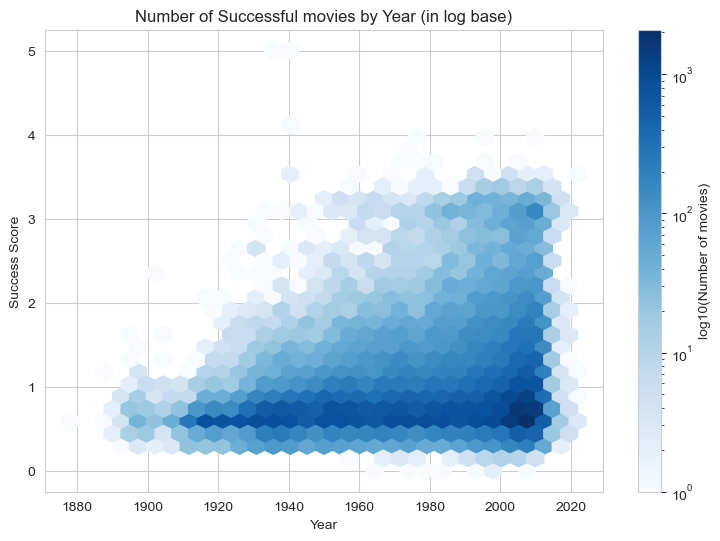

In [3]:
# Hexbin plot
# Create a copy to not modify our final dataframe
# Keeping only the year as we are looking at year distribution
success_by_year = movies.copy()
success_by_year['year'] = pd.to_datetime(success_by_year['combined_release_date']).dt.year
plt.figure(figsize=(9, 6))
plt.hexbin(success_by_year['year'], success_by_year['success_metric_scaled'],gridsize=30,cmap='Blues',bins='log')
plt.colorbar(label='log10(Number of movies)')

# Set the title and labels
plt.xlabel('Year')
plt.ylabel('Success Score')
plt.title('Number of Successful movies by Year (in log base)')

plt.savefig('plots/movie_success_hexbin.png', dpi=300, bbox_inches='tight')
plt.show()



This plot represent the number of movies of a particular genre released per year.

This plot represent the distribution of the success metric assigned to the movies.


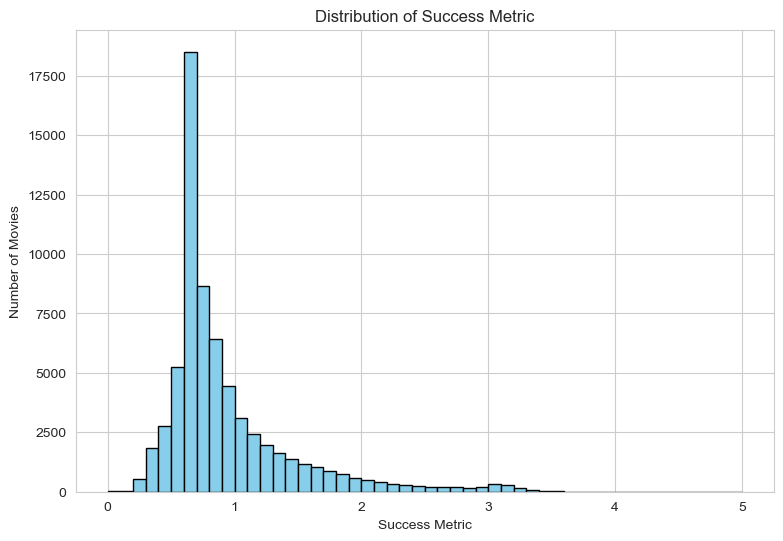

In [4]:
# Create a histogram of the Success_metric
plt.figure(figsize=(9, 6))
plt.hist(movies['success_metric_scaled'].dropna(), bins=50, color='skyblue', edgecolor='black')

# Set the title and labels
plt.title('Distribution of Success Metric')
plt.xlabel('Success Metric')
plt.ylabel('Number of Movies')

# Show the plot
plt.savefig('plots/success_metric_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Line plot
# Keeping only the year as we are looking at year distribution
movies['year'] = pd.to_datetime(movies['combined_release_date']).dt.year
# Explode the genres to have one genre per row to be able to count them
movies['movie_genres_final'] = movies['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
n_genre_per_year = movies.explode('movie_genres_final')
# Keep only the top 20 genres
genre_counts = n_genre_per_year['movie_genres_final'].value_counts()
best_genres = genre_counts.head(20).index.tolist()
n_genre_per_year = n_genre_per_year[n_genre_per_year['movie_genres_final'].isin(best_genres)]
# Ensure the order of the genres
n_genre_per_year['movie_genres_final'] = pd.Categorical(n_genre_per_year['movie_genres_final'],categories=best_genres, ordered=True)
# Count the number of movies per genre per year
n_genre_per_year = n_genre_per_year.groupby(['year', 'movie_genres_final']).size().reset_index(name='movie_count')
# Defining the Line Plot
fig = px.line(n_genre_per_year, x='year', y='movie_count', color='movie_genres_final',
              title='Top 15 Movies Count by Genre Over Time',
              labels={'year': 'Release Year', 'movie_count': 'Number of Movies', 'movie_genres_final': 'Genres'},
            #   height=420,
            #   width=720
              )

# Update layout to set white background
fig.update_layout(
    legend=dict(itemclick="toggleothers")  # Allow toggling of the genres in the legend
)

# Show the plot
fig.write_html('plots/movie_counts_by_genre.html', full_html=True, default_width='730px', default_height='430px')
fig.show()

In [6]:
# Histogram
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=movies['success_metric_scaled'],
    nbinsx=75,
    marker_color='skyblue',
    opacity=0.7
))

fig.update_layout(
    title='Success Score Distribution',
    xaxis_title='Success Score',
    yaxis_title='Number of Movies',
    template='plotly_white',
    hovermode='closest',
    yaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=4000,
        tickformat='d',
    ),
    # height=420,
    # width=720,
)

fig.write_html('plots/success_score_distribution.html', full_html=False)
fig.show()


In [7]:
# Donut chart
# Movies have more than one genre, so we need to explode the genres to count them
movies_pie_df = movies.copy()
movies_pie_df['movie_genres_final'] = movies_pie_df['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
genre_per_film = movies.explode('movie_genres_final')
# Put the genres that are not in the top 20 represented in our dataframe in the "Others" category
n_genres = genre_per_film['movie_genres_final'].value_counts()
top_20_genres = n_genres.head(20).index.tolist()
top_15_genres = n_genres.head(15).index.tolist()
genre_per_film['movie_genres_final'] = genre_per_film['movie_genres_final'].apply(lambda x: x if x in top_20_genres else 'Others')
# Recalculate the number of movies per genre with the new "Others" category
n_genres = genre_per_film['movie_genres_final'].value_counts().reset_index()
n_genres.columns = ['Genre', 'Count']
fig = px.pie(
    n_genres,
    names='Genre',
    values='Count',
    title='Distribution of Number of Movies by Genre',
    hole=0.4
)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(showlegend=True, height=600)

fig.write_html('plots/genre_piechart.html', full_html=False)
fig.show()

This plot shows the mean success by country. We see that surprsingly, China is the country with the highest mean success metric.


In [8]:
# Deal with movies with multiple countries
movies['movie_countries_final'] = movies['movie_countries_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
all_countries_per_film = movies.explode('movie_countries_final')

country_success = all_countries_per_film.groupby('movie_countries_final', group_keys=False).apply(lambda x: x.nlargest(100, 'success_metric_scaled')).groupby('movie_countries_final')['success_metric_scaled'].mean().reset_index()
country_success.sort_values('success_metric_scaled', ascending=False, inplace=True)
country_success.reset_index(drop=True, inplace=True)
country_success.head()

,movie_countries_final,success_metric_scaled
0,United States of America,3.473049
1,United Kingdom,3.201491
2,Japan,3.005623
3,Germany,2.985293
4,France,2.934487


In [9]:
# Choropleth map to display mean success score for the top 100 movies per country
fig = px.choropleth(
    country_success,
    locations='movie_countries_final',
    locationmode='country names',
    color='success_metric_scaled',
    hover_name='movie_countries_final',
    color_continuous_scale='Blues',
    labels={'success_metric_scaled': 'Mean Success Metric'},
    title='World Map of Mean Success Score by Country'
)
fig.write_html('plots/top_100_mean_success_score_map.html', full_html=False)
fig.show()

Very beautiful plot to display the most successfull movies

In [15]:
# Sort movies by success
most_successful = movies.sort_values(by='success_metric_scaled', ascending=False)

# Precompute data for Top 5, 10, 25, and 50
precomputed_data = {
    'Top 5': most_successful.head(5),
    'Top 10': most_successful.head(10),
    'Top 25': most_successful.head(25),
    'Top 50': most_successful.head(50),
}

# Bar Chart
def plot_top_movies(data, title):
    fig = px.bar(data,
                 x='movie_name',
                 y='success_metric_scaled',
                 title=title,
                 labels={'movie_name': 'Movie', 'success_metric_scaled': 'Success Score'},
                 hover_data=['movie_name', 'success_metric_scaled', 'Box_Office', 'rating'],
                 color_discrete_sequence=['skyblue'])
    fig.update_layout(
        xaxis_title="Movie",
        yaxis_title="Success Metric",
        xaxis_tickangle=-60,
        height=600,
    )
    return fig

# Initialize the first figure
initial_data = precomputed_data['Top 5']
fig = plot_top_movies(initial_data, "Top 5 Movies by Success Metric")

# Create radio buttons for interactivity
buttons = []
for label, data in precomputed_data.items():
    buttons.append(
        dict(
            label=label,
            method="update",
            args=[
                {"x": [data['movie_name']], "y": [data['success_metric_scaled']]},
                {"title": f"{label} Movies by Success Metric"}
            ]
        )
    )

# Add radio buttons to the layout
fig.update_layout(
    title={
        "text": "Top 5 Movies by Success Metric",
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top"
    },
    updatemenus=[{
        "buttons": buttons,
        "direction": "up",
        "showactive": True,
        "x": 1.01,
        "xanchor": "left",
        "y": 0.5,
        "yanchor": "middle",
        "type": "buttons",
    }],
    margin=dict(l=20, r=80, t=50, b=20),
)

# Write to a standalone HTML file
fig.write_html("plots/top_movies_vertical_radiobuttons.html")
fig.show()

One simple way to compute the golden age of each genre, will be to take THE ONE Year of the genre with the most success (mean success of the genre this particular year is the highest)

In [11]:
movies['movie_genres_final'] = movies['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
movies['release_year'] = pd.to_datetime(movies['combined_release_date']).dt.year
movies.sort_values(by='success_metric_scaled', ascending=False, inplace=True)
# This plot is by decade, by genre
movies['decade'] = movies['release_year'].apply(get_decade)
all_genres_per_film = movies.explode('movie_genres_final')

# Let's keep only the top 20
popular_genres = all_genres_per_film['movie_genres_final'].value_counts().head(20).index
popular_movies_genre = all_genres_per_film[all_genres_per_film['movie_genres_final'].isin(top_20_genres)]

# Compute the mean success score and the number of released movie by decade and genre
grouped = popular_movies_genre.groupby(['decade', 'movie_genres_final']).agg(
    count=('movie_genres_final', 'size'),
    mean_success_score=('success_metric_scaled', 'mean')
).reset_index()
grouped_sorted = grouped.sort_values(by='mean_success_score', ascending=False)

# Bubble chart
fig = px.scatter(
    grouped_sorted,
    x='decade',
    y='mean_success_score',
    size='count',
    color='movie_genres_final',
    hover_name='movie_genres_final',
    title='Mean Success Score & Number of Movies by Decade in the Top 20 Genres',
    labels={'decade': 'Decade', 'mean_success_score': 'Mean Success Score', 'count': 'Count'},
    size_max=50
)
fig.update_layout(
    xaxis_title="Decade",
    yaxis_title="Mean Success Score",
    legend_title="Genre",
    template="plotly",
    yaxis=dict(range=[0.5, 1.9]),
    #xaxis=dict(range=[1895, grouped_sorted['decade'].max()]),
    xaxis=dict(range=[1895, 2015]),
    height=600,
    width = 720,
    legend=dict(itemclick="toggleothers")
)
fig.show()
fig.write_html('plots/bubble_plot.html', full_html=False)

In [12]:
# Get the most represented genres in the dataset
movies['movie_genres_final'] = movies['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
movies['release_year'] = pd.to_datetime(movies['combined_release_date']).dt.year
all_genres_per_film = movies.explode('movie_genres_final')
popular_genres = all_genres_per_film['movie_genres_final'].value_counts().head(15).index
popular_movies_genre = all_genres_per_film[all_genres_per_film['movie_genres_final'].isin(top_15_genres)]
#Group by genre and year and compute the mean success score
genre_year_success = popular_movies_genre.groupby(['movie_genres_final', 'release_year'])['success_metric_scaled'].mean().reset_index()
golden_age = genre_year_success.loc[genre_year_success.groupby('movie_genres_final')['success_metric_scaled'].idxmax()]
golden_age = golden_age.rename(columns={'release_year': 'Golden Age Year', 'success_metric_scaled': 'Max Success Metric'})
# Bar plot with success
fig = px.bar(
    golden_age,
    x='Golden Age Year',
    y='movie_genres_final',
    color='Max Success Metric',
    title='Most Successful Year by Genre',
    labels={'movie_genres_final': 'Genre', 'Golden Age Year': 'Year', 'Max Success Metric': 'Success Metric'},
    hover_data=['Max Success Metric'],
    color_continuous_scale='Blues'
)
fig.update_layout(
    xaxis=dict(title='Golden Age Year', range=[1800, pd.Timestamp.now().year]),
    yaxis_title="Genre",
    plot_bgcolor='#f0f0f0',
    height=600,
    width=720
)
fig.show()
fig.write_html('plots/horbar.html', full_html=False)

In [13]:
# Get the most represented genres in the dataset
movies['movie_genres_final'] = movies['movie_genres_final'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
movies['release_year'] = pd.to_datetime(movies['combined_release_date']).dt.year
movies['decade'] = (movies['release_year'] // 10) * 10
all_genres_per_film = movies.explode('movie_genres_final')
#Group by genre and year and compute the mean success score
top_15_genres = all_genres_per_film['movie_genres_final'].value_counts().head(15).index
popular_movies_genre = all_genres_per_film[all_genres_per_film['movie_genres_final'].isin(top_20_genres)]
genre_decade_success = popular_movies_genre.groupby(['movie_genres_final', 'decade'])['success_metric_scaled'].mean().reset_index()
# Identify Golden age/deacde
golden_age = genre_decade_success.loc[genre_decade_success.groupby('movie_genres_final')['success_metric_scaled'].idxmax()]
golden_age = golden_age.rename(columns={'decade': 'Golden Age/ Most Successful Decade', 'success_metric_scaled': 'Max Success Metric'})
# Bar plot with success
fig = px.bar(
    golden_age,
    x='Golden Age/ Most Successful Decade',
    y='movie_genres_final',
    color='Max Success Metric',
    title='Most Successful Decade by Genre',
    labels={'movie_genres_final': 'Genre', 'Golden Age/ Most Successful Decade': 'Decade', 'Max Success Metric': 'Success Metric'},
    hover_data=['Max Success Metric'],
    color_continuous_scale='Blues'
)
fig.update_layout(
    xaxis=dict(title='Golden Age/ Most Successful Decade', range=[1800, pd.Timestamp.now().year]),
    yaxis_title="Genre",
    plot_bgcolor='#f0f0f0',
    height=600,
    width=720
)
fig.show()
fig.write_html('plots/horbar_decade.html', full_html=False)

# Plots for part 3

In [9]:
impact_data_dir = "./data/Impact_Timeseries/"
import_impact_array = []

for file_name in os.listdir(impact_data_dir):
    if file_name.endswith(".csv"): 
        genre_name = file_name.replace(".csv", "").replace("_", " ").replace("2", "/")
        file_path = os.path.join(impact_data_dir, file_name)
        df = pd.read_csv(file_path, names=["Date", "Impact"], header=0, parse_dates=['Date'])
        df = df.drop(index=0)
        df['Genre'] = genre_name  
        import_impact_array.append(df)

import_impact_df = pd.concat(import_impact_array, ignore_index=True)
import_impact_df.head()

,Date,Impact,Genre
0,1902-10-14,0.0,Action
1,1902-10-15,0.0,Action
2,1902-10-16,0.0,Action
3,1902-10-17,0.0,Action
4,1902-10-18,0.0,Action


In [10]:
selected_dates = ['1935-01-01', '1965-01-01', '1980-01-01', '1999-01-01', '2015-01-01']
selected_data = import_impact_df[import_impact_df['Date'].isin(pd.to_datetime(selected_dates))].copy()

selected_data['Relative Impact'] = selected_data.groupby('Date')['Impact'].transform(
    lambda x: x / x.sum()
)

plot_data = selected_data.pivot(index='Genre', columns='Date', values='Relative Impact')
plot_data = plot_data.reindex(sorted(plot_data.index)) 

fig = go.Figure()

for date in selected_dates:
    fig.add_trace(go.Scatterpolar(
        r=plot_data[date].fillna(0).values,
        theta=plot_data.index,
        fill='toself',
        name=str(date)
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 0.4])  
    ),
    title=dict(
        text='Relative Impact of Genres at Selected Dates',
        x=0.5,  
        y=0.95,  
        xanchor='center',
        yanchor='top'
    ),
    legend=dict(
        title='Dates',
        orientation="h",  
        x=0.5,
        y=-0.1,
        xanchor='center',
        yanchor='top'
    ),
    width=800,  
    height=800, 
)

fig.show()
fig.write_html("./plots/relativeImpactRadar.html", full_html=False)